In [1]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
sys.path.insert(0,"../")
from castle import train_ensamble_linear_model, train_linear_model, ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

In [2]:
species = 'Si'
N = 5
maxdeg = 8
rcut = rcuts[species]
force_name = 'dft_force'
energy_name = 'dft_energy'
noise = 1e-8

root = f"/home/claudio/postdoc/data/Si_gabor/"

# tr_features, val_features = utils.extract_features(root, "train.xyz", "test.xyz",
#                                              N=N, maxdeg=maxdeg, rcut=rcut, force_name = force_name, energy_name =energy_name,
#                                             species = species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train.xyz", "test.xyz",
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

CPU times: user 28.9 ms, sys: 52 ms, total: 80.9 ms
Wall time: 11.6 ms
MAE=0.030 RMSE=0.083 SUP=1.045 R2=0.986
MAE=0.136 RMSE=0.207 SUP=5.991 R2=0.938


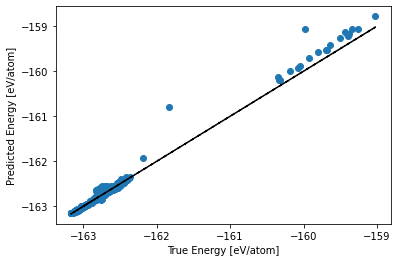

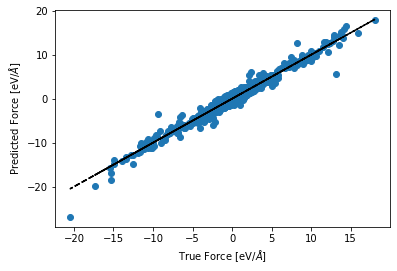

In [3]:
model_lin = train_linear_model(tr_features, noise, e_t, f_t)

# evaluate its performances
%time ep, fp = model_lin.predict(val_features)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

CPU times: user 1.01 s, sys: 549 ms, total: 1.56 s
Wall time: 885 ms
MAE=0.014 RMSE=0.033 SUP=0.263 R2=0.997
MAE=0.121 RMSE=0.183 SUP=1.881 R2=0.950


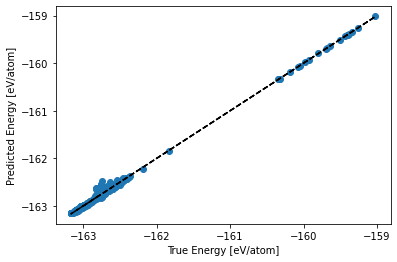

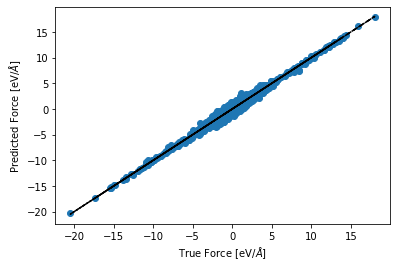

In [4]:
n_clusters = 10
# train the model
model_ens =  train_ensamble_linear_model(tr_features, noise, e_t, f_t,
                         n_clusters=n_clusters, clustering='gmm')

# evaluate its performances
%time ep, fp = model_ens.predict(val_features)
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

In [5]:
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS
from ase.optimize import FIRE
from ase.optimize import MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units
from ase import Atoms

In [15]:
calc_lin = ASEMLCalculator(model_lin, model_lin.representation)
calc_ens = ASEMLCalculator(model_ens, model_ens.representation)

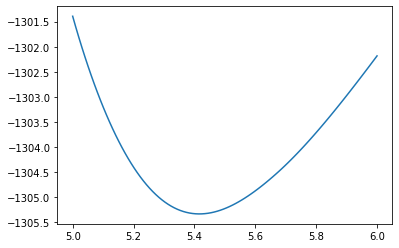

In [10]:
num = 100
en = np.zeros(num)
distances = np.linspace(5, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_lin)
    en[i] = atoms.get_potential_energy()
    
plt.plot(distances, en)
plt.show()

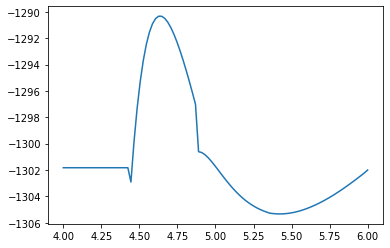

In [38]:
num = 100
en = np.zeros(num)
distances = np.linspace(4, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_ens)
    en[i] = atoms.get_potential_energy()
    
plt.plot(distances, en)
plt.show()

In [39]:
atoms = bulk('Si', 'diamond', a=4.9, cubic=True)
atoms.set_calculator(calc_ens)
en[i] = atoms.get_potential_energy()

In [40]:
# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=1000)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(2000):
    dyn.run(100)
    printenergy(atoms)

Energy per atom: Epot = -162.579eV  Ekin = 0.101eV (T=779K)  Etot = -162.478eV
Energy per atom: Epot = -162.351eV  Ekin = 0.326eV (T=2524K)  Etot = -162.024eV
Energy per atom: Epot = -162.443eV  Ekin = 0.419eV (T=3240K)  Etot = -162.025eV
Energy per atom: Epot = -162.242eV  Ekin = 0.326eV (T=2520K)  Etot = -161.916eV
Energy per atom: Epot = -162.462eV  Ekin = 0.565eV (T=4368K)  Etot = -161.897eV
Energy per atom: Epot = -162.261eV  Ekin = 0.364eV (T=2817K)  Etot = -161.897eV
Energy per atom: Epot = -162.408eV  Ekin = 0.511eV (T=3953K)  Etot = -161.897eV
Energy per atom: Epot = -162.427eV  Ekin = 0.529eV (T=4096K)  Etot = -161.897eV
Energy per atom: Epot = -162.261eV  Ekin = 0.541eV (T=4182K)  Etot = -161.720eV
Energy per atom: Epot = -162.467eV  Ekin = 0.745eV (T=5766K)  Etot = -161.721eV
Energy per atom: Epot = -162.490eV  Ekin = 0.767eV (T=5933K)  Etot = -161.723eV
Energy per atom: Epot = -162.489eV  Ekin = 0.767eV (T=5931K)  Etot = -161.722eV
Energy per atom: Epot = -162.348eV  Ekin 

KeyboardInterrupt: 